In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt

In [6]:
# Load dataset
data = pd.read_csv("parkinsons (1).data")

In [3]:
# Preprocess the data
X = data.drop(columns=['name', 'status'])
y = data['status']

In [4]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# Reshape data for LSTM input (samples, timesteps, features)
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [7]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(128, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(X_train.shape[1], activation='linear')  # Output features for XGBoost
])

C:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Compile LSTM model
lstm_model.compile(optimizer='adam', loss='mse')

In [9]:
# Train LSTM model
lstm_model.fit(X_train_lstm, X_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 1.0188 - val_loss: 1.0874
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1545 - val_loss: 1.0537
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0265 - val_loss: 1.0002
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0866 - val_loss: 0.9124
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0400 - val_loss: 0.7950
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9095 - val_loss: 0.6739
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7060 - val_loss: 0.5861
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6242 - val_loss: 0.5400
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4344 - val_loss: 0.4901
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4179 - val_loss: 0.4475
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3843 - val_loss: 0.4190
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4080 - val_loss: 0.3954


In [10]:
# Extract features from LSTM
X_train_lstm_features = lstm_model.predict(X_train_lstm)
X_test_lstm_features = lstm_model.predict(X_test_lstm)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [11]:
# Train XGBoost model
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
xgb_model.fit(X_train_lstm_features, y_train)

C:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:36:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [12]:
# Evaluate the hybrid model
train_accuracy = xgb_model.score(X_train_lstm_features, y_train)
test_accuracy = xgb_model.score(X_test_lstm_features, y_test)

In [13]:
# Train and evaluate standalone XGBoost
xgb_model_single = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
xgb_model_single.fit(X_train, y_train)
xgb_train_accuracy = xgb_model_single.score(X_train, y_train)
xgb_test_accuracy = xgb_model_single.score(X_test, y_test)

C:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:36:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [14]:
# Train and evaluate standalone LSTM
lstm_model_single = Sequential([
    LSTM(128, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

lstm_model_single.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model_single.fit(X_train_lstm, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

C:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.7077 - loss: 0.6847 - val_accuracy: 0.9062 - val_loss: 0.6615
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7787 - loss: 0.6592 - val_accuracy: 0.8438 - val_loss: 0.6142
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8074 - loss: 0.6139 - val_accuracy: 0.8438 - val_loss: 0.5442
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7917 - loss: 0.5519 - val_accuracy: 0.9062 - val_loss: 0.4644
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7678 - loss: 0.4736 - val_accuracy: 0.9062 - val_loss: 0.4058
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8389 - loss: 0.4132 - val_accuracy: 0.9062 - val_loss: 0.3657
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7715 - loss: 0.4303 - val_accuracy: 0.8750 - val_loss: 0.3372
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7519 - loss: 0.3671 - val_accuracy: 0.8750 - val_loss: 0.3165


In [15]:
# Evaluate standalone LSTM
lstm_train_accuracy = lstm_model_single.evaluate(X_train_lstm, y_train, verbose=0)[1]
lstm_test_accuracy = lstm_model_single.evaluate(X_test_lstm, y_test, verbose=0)[1]

In [16]:
# Metrics for hybrid model
hybrid_preds = xgb_model.predict(X_test_lstm_features)
hybrid_probs = xgb_model.predict_proba(X_test_lstm_features)[:, 1]
hybrid_accuracy = accuracy_score(y_test, hybrid_preds)
hybrid_precision = precision_score(y_test, hybrid_preds)
hybrid_recall = recall_score(y_test, hybrid_preds)
hybrid_f1 = f1_score(y_test, hybrid_preds)
hybrid_roc_auc = roc_auc_score(y_test, hybrid_probs)

In [17]:
# Metrics for standalone XGBoost
xgb_preds = xgb_model_single.predict(X_test)
xgb_probs = xgb_model_single.predict_proba(X_test)[:, 1]
xgb_precision = precision_score(y_test, xgb_preds)
xgb_recall = recall_score(y_test, xgb_preds)
xgb_f1 = f1_score(y_test, xgb_preds)
xgb_roc_auc = roc_auc_score(y_test, xgb_probs)

In [18]:
# Metrics for standalone LSTM
lstm_preds = lstm_model_single.predict(X_test_lstm)
lstm_preds_binary = (lstm_preds > 0.5).astype(int)
lstm_precision = precision_score(y_test, lstm_preds_binary)
lstm_recall = recall_score(y_test, lstm_preds_binary)
lstm_f1 = f1_score(y_test, lstm_preds_binary)
lstm_roc_auc = roc_auc_score(y_test, lstm_preds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 496ms/step


In [19]:
# Print metrics
print("Performance Metrics:")
print(f"Hybrid Model - Accuracy: {hybrid_accuracy:.2f}, Precision: {hybrid_precision:.2f}, Recall: {hybrid_recall:.2f}, F1-Score: {hybrid_f1:.2f}, ROC AUC: {hybrid_roc_auc:.2f}")
print(f"Standalone XGBoost - Accuracy: {xgb_test_accuracy:.2f}, Precision: {xgb_precision:.2f}, Recall: {xgb_recall:.2f}, F1-Score: {xgb_f1:.2f}, ROC AUC: {xgb_roc_auc:.2f}")
print(f"Standalone LSTM - Accuracy: {lstm_test_accuracy:.2f}, Precision: {lstm_precision:.2f}, Recall: {lstm_recall:.2f}, F1-Score: {lstm_f1:.2f}, ROC AUC: {lstm_roc_auc:.2f}")

Performance Metrics:
Hybrid Model - Accuracy: 0.95, Precision: 0.97, Recall: 0.97, F1-Score: 0.97, ROC AUC: 0.99
Standalone XGBoost - Accuracy: 0.92, Precision: 0.93, Recall: 0.97, F1-Score: 0.95, ROC AUC: 0.96
Standalone LSTM - Accuracy: 0.87, Precision: 0.90, Recall: 0.93, F1-Score: 0.92, ROC AUC: 0.96


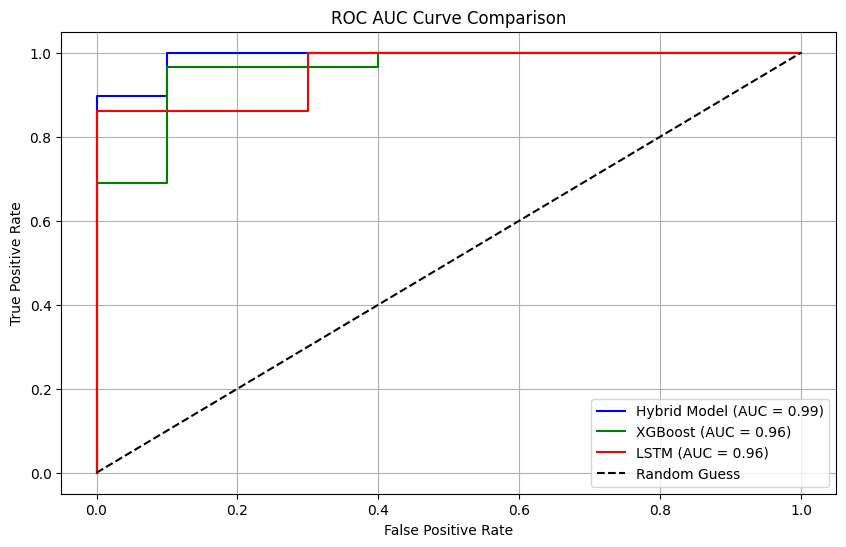

In [20]:
# Plot ROC curves
fpr_hybrid, tpr_hybrid, _ = roc_curve(y_test, hybrid_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_preds)
plt.figure(figsize=(10, 6))
plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model (AUC = {hybrid_roc_auc:.2f})', color='blue')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_roc_auc:.2f})', color='green')
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {lstm_roc_auc:.2f})', color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC AUC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

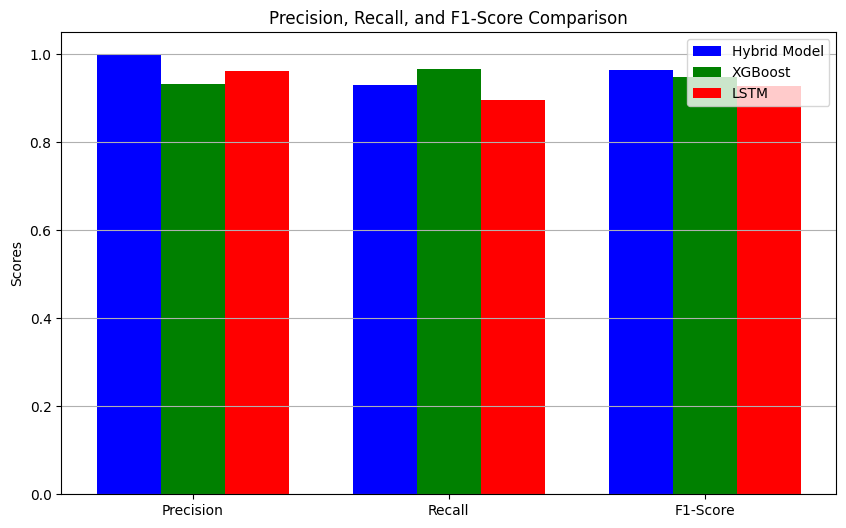

In [48]:
# Bar plot for precision, recall, and F1-score
metrics = ['Precision', 'Recall', 'F1-Score']
hybrid_scores = [hybrid_precision, hybrid_recall, hybrid_f1]
xgb_scores = [xgb_precision, xgb_recall, xgb_f1]
lstm_scores = [lstm_precision, lstm_recall, lstm_f1]

x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, hybrid_scores, width, label='Hybrid Model', color='blue')
plt.bar(x, xgb_scores, width, label='XGBoost', color='green')
plt.bar(x + width, lstm_scores, width, label='LSTM', color='red')

plt.xticks(x, metrics)
plt.ylabel('Scores')
plt.title('Precision, Recall, and F1-Score Comparison')
plt.legend()
plt.grid(axis='y')
plt.show()

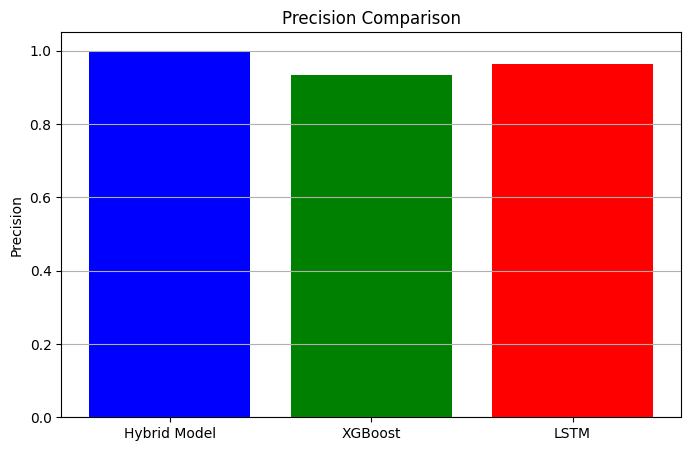

In [49]:
# Precision bar plot
plt.figure(figsize=(8, 5))
plt.bar(['Hybrid Model', 'XGBoost', 'LSTM'], [hybrid_precision, xgb_precision, lstm_precision], color=['blue', 'green', 'red'])
plt.title('Precision Comparison')
plt.ylabel('Precision')
plt.grid(axis='y')
plt.show()



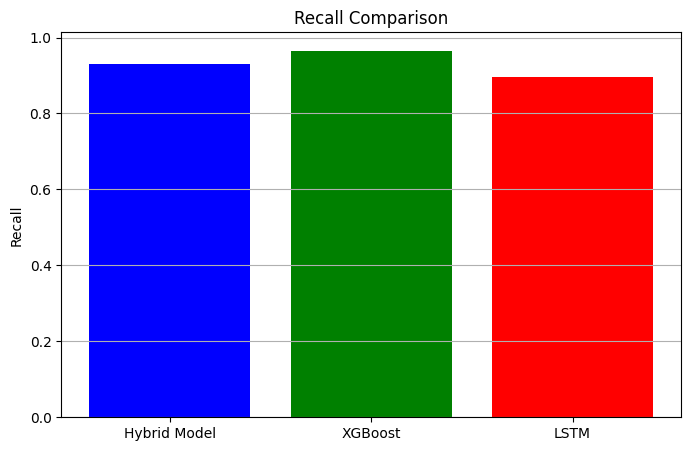

In [50]:
# Recall bar plot
plt.figure(figsize=(8, 5))
plt.bar(['Hybrid Model', 'XGBoost', 'LSTM'], [hybrid_recall, xgb_recall, lstm_recall], color=['blue', 'green', 'red'])
plt.title('Recall Comparison')
plt.ylabel('Recall')
plt.grid(axis='y')
plt.show()

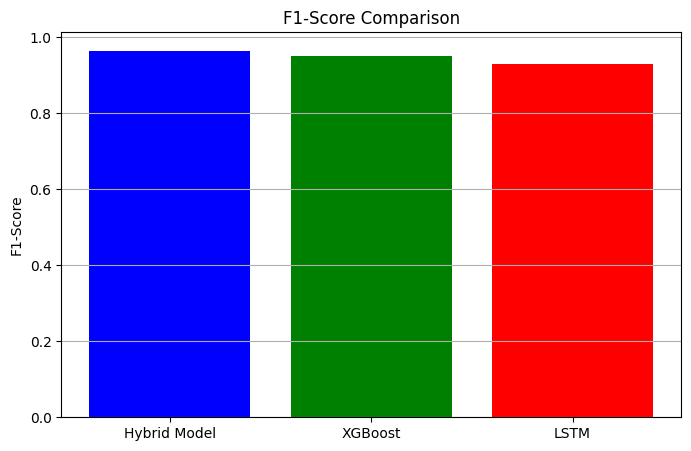

In [51]:
# Bar plot for F1-score comparison
plt.figure(figsize=(8, 5))
plt.bar(['Hybrid Model', 'XGBoost', 'LSTM'], [hybrid_f1, xgb_f1, lstm_f1], color=['blue', 'green', 'red'])
plt.title('F1-Score Comparison')
plt.ylabel('F1-Score')
plt.grid(axis='y')
plt.show()


In [52]:
# Test with custom input
def test_custom_input(custom_input):
    custom_input_scaled = scaler.transform([custom_input])
    custom_input_lstm = custom_input_scaled.reshape(1, 1, custom_input_scaled.shape[1])
    custom_features = lstm_model.predict(custom_input_lstm)
    prediction = xgb_model.predict(custom_features)
    return "Parkinson's Detected" if prediction[0] == 1 else "No Parkinson's"

In [53]:
custom_inputs = [
    [119.992, 157.302, 74.997, 0.00784, 0.00007, 0.00370, 0.00554, 0.01109, 0.04374, 0.426, 0.02182, 0.0313, 0.02971, 0.06545, 0.02211, 21.033, 0.414783, 0.815285, -4.813031, 0.266482, 2.301442, 0.284654],
    [122.4, 148.65, 113.819, 0.00968, 0.00008, 0.00465, 0.00696, 0.01394, 0.06134, 0.626, 0.03134, 0.04518, 0.04368, 0.09403, 0.01929, 19.085, 0.458359, 0.819521, -4.075192, 0.33559, 2.486855, 0.368674],
    [116.682, 131.111, 111.555, 0.0105, 0.00009, 0.00544, 0.00781, 0.01633, 0.05233, 0.482, 0.02757, 0.03858, 0.0359, 0.0827, 0.01309, 20.651, 0.429895, 0.825288, -4.443179, 0.311173, 2.342259, 0.332634],
    [120.552, 131.162, 113.787, 0.00968, 0.00008, 0.00463, 0.0075, 0.01388, 0.04701, 0.456, 0.02328, 0.03526, 0.03243, 0.06985, 0.01222, 21.378, 0.415564, 0.825069, -4.242867, 0.299111, 2.18756, 0.357775],
    [116.014, 141.781, 110.655, 0.01284, 0.00011, 0.00655, 0.00908, 0.01966, 0.06425, 0.584, 0.0349, 0.04825, 0.04465, 0.1047, 0.01767, 19.649, 0.417356, 0.823484, -3.747787, 0.234513, 2.33218, 0.410335],
    [130.5, 150.0, 120.0, 0.002, 0.00001, 0.001, 0.002, 0.004, 0.015, 0.150, 0.005, 0.007, 0.010, 0.020, 0.005, 25.0, 0.300, 0.750, -5.5, 0.150, 1.800, 0.150]
]

for idx, custom_input in enumerate(custom_inputs):
    result = test_custom_input(custom_input)
    print(f"Test {idx + 1}: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Test 1: Parkinson's Detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Test 2: Parkinson's Detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Test 3: Parkinson's Detected


C:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Test 4: Parkinson's Detected
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Test 5: Parkinson's Detected


C:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Test 6: No Parkinson's


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Sample Data (Replace with actual dataset)
data = pd.DataFrame({
    'feature1': np.random.rand(100),
    'feature2': np.random.rand(100),
    'feature3': np.random.rand(100),
    'label': np.random.randint(0, 2, 100)
})

# Splitting features and labels
X = data.drop(columns=['label'])
y = data['label']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

